<a href="https://colab.research.google.com/github/EWECORP/DScience_41870/blob/main/Desafio_CrossValidation_Eduardo_Ettlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

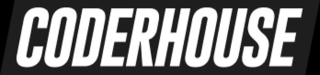

# **CURSO DE DATA SCIENCE**

# **DESAFIO  CROSS VALIDATION**

# **DESAFIO N° 15**

*AUTOR:Eduardo ETTLIN*

Entrenar uno de los modelos elegidos con las mismas variables pero aplicando alguno de los métodos aprendidos de validación cruzada

Describir si hay cambios en el performance del modelo y explicar con razones el porqué

Se recomienda utilizar entre 5-10 folds para el proceso de CrossValidation con el fin de optimizar el tiempo de ejecución de la técnica


In [1]:
  #Conectamos mi drive
  from google.colab import drive
  #Importamos OS
  import os
  #Montamos drive
  drive.mount('/content/gdrive', force_remount=True)
# Establecer ruta de acceso en drive
import os
print(os.getcwd())

Mounted at /content/gdrive
/content


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install featuretools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.3/618.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 6.9 MB/s eta 0:00:00


In [4]:
# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [5]:
# Me muevo a la carpeta
os.chdir("/content/gdrive/MyDrive/DScience_41870")
print(os.getcwd())

#Lectura del dataframe
datos=pd.read_csv('/content/gdrive/MyDrive/DScience_41870/US_Accidents_Dec21_updated.csv',sep=',',nrows=2845000)  # nrows: 1500000  # Disminuir Tamaño a 1.5 MM (Riginalmente Tiene 2.845.342 registros)

/content/gdrive/MyDrive/DScience_41870


In [45]:
datos.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


# REDUCCIÓN DEL DATASET - Es Muy Grande para PROCESARLO

Se utilizara la función sample para muestrear todo el DataSet.

PROBAR RANDOMIZED SEARCH
HYPER OPT
BAYES GRID SEARCH (Probabilisticos)

In [46]:
## df= datos.sample(10000)   # Achicar el Set de Datos porque no alcanza a calcular.

df =  datos[(datos['Start_Time'] > '2020-01-01 00:00:00')]

In [47]:
df.Severity.unique()

array([2, 4, 1, 3])

In [48]:
df.shape

(2137609, 47)

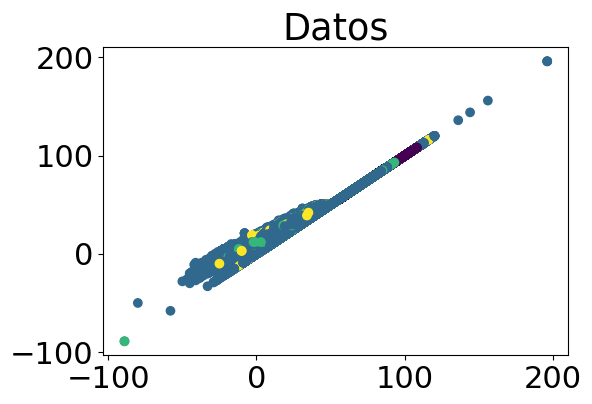

In [50]:
#Visualizacion!
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Wind_Chill(F)'], df['Temperature(F)'], c=df.Severity);
ax.set_title("Datos");

In [51]:
# Reemplazo de los vacíos
X = df.fillna(0, inplace=True)

# Enriquecer el Modelo
Con variables derivadas de las existentes

In [52]:
df['Hora'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.hour  # Extraer la HORA del Día en la
df['Anio_Mes'] =  pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')  # Extraer AÑO y MES

df['day_of_week'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana
days = {0:'Lunes',1:'Martes',2:'Miércoeles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
df['day_of_week'] = df['day_of_week'].apply(lambda x: days[x])

df['Mes'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES


In [53]:

df['DiaS'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana

In [54]:
## Identificar la Estación Climática

def estacion_climatica(mes):
  if mes.lower() in ('january','february','march'):
    return 'Invierno'
  elif mes.lower() in ('april','may','june'):
    return 'Primavera'
  elif mes.lower() in ('july','august','september'):
    return 'Verano'
  else:
    return 'Otoño'

In [55]:
df['estacion_meteorologica'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES
df['estacion_meteorologica'] = df['estacion_meteorologica'].apply(estacion_climatica)

In [56]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Hora', 'Anio_Mes', 'day_of_week', 'Mes',
       'DiaS', 'estacion_meteorologica'],
      dtype='object')

In [57]:
# División de los datos en train y test
X = df.drop(columns = ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone','Airport_Code', 'Weather_Timestamp',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Hora', 'Anio_Mes', 'day_of_week', 'Mes', 'DiaS', 'estacion_meteorologica',
       'Astronomical_Twilight'], axis= 1) # Matriz de 2 columnas -Variable Independientes # 'Temperature(F)', 'Wind_Chill(F)',
y = df['Severity'] # Vector de 200 filas y 1 columna- Variable Dependiente

In [58]:
#Visualizar X
X

,Temperature(F),Wind_Chill(F)
224945,42.0,36.0
224946,54.0,54.0
224947,79.0,79.0
224948,38.0,38.0
224949,52.0,52.0
...,...,...
2362657,59.0,59.0
2362658,43.0,43.0
2362659,64.0,64.0
2372960,28.0,19.0


In [59]:
#Visualizar y
y

224945     2
224946     2
224947     2
224948     2
224949     2
          ..
2362657    2
2362658    2
2362659    2
2372960    2
2372993    4
Name: Severity, Length: 2137609, dtype: int64

In [60]:
print(X.shape, y.shape)

(2137609, 2) (2137609,)


In [61]:
# Separar en train y test
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(1496326, 2) (641283, 2)


# Seleccion manual

In [62]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [63]:
model= xgb.XGBClassifier(learning_rate=0.001)
# Lista de hiperparametros
params_1 = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}
params_2 = {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7}
params_3 = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10}

## Estos procesos pueden demorar bastante !!

In [ ]:
# Modelo 1
model.set_params(**params_1).fit(X_train, y_train)
print(f'Accuracy para Modelo 1 = {round(accuracy_score(y_test, model.predict(X_test)), 5)}')
# Modelo 2
model.set_params(**params_2).fit(X_train, y_train)
print(f'Accuracy para Modelo 2 = {round(accuracy_score(y_test, model.predict(X_test)), 5)}')
# Modelo 3
model.set_params(**params_3).fit(X_train, y_train)
print(f'Accuracy para Modelo 3 = {round(accuracy_score(y_test, model.predict(X_test)), 5)}')

[21:37:48] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "splitter" } are not used.

Accuracy para Modelo 1 = 0.01223
[21:41:28] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "splitter" } are not used.

Accuracy para Modelo 2 = 0.01223
[21:46:47] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "splitter" } are not used.



# Grid Search

In [29]:
params_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,6,7],
        'criterion':['entropy','gini']
        }

In [ ]:
# tiempo de ejecucuon 424 seg
grid_cv = GridSearchCV(model, params_grid, scoring="accuracy",  error_score='raise',n_jobs=-1, cv=3)
grid_cv.fit(X_train, y_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(X_test)), 5)}')

# Randomized Search CV

In [ ]:
# tiempo de ejecucuon 7 seg
grid_cv = RandomizedSearchCV(model, params_grid, scoring="accuracy", error_score='raise', n_jobs=-1, cv=3)
grid_cv.fit(X_train, y_train)

print("Mejores parametros", grid_cv.best_params_)
print("Mejor score de CV", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(X_test)), 5)}')

# Halving Grid Search

In [ ]:
# tiempo de ejecucuon 125 seg
halving_cv = HalvingGridSearchCV(model, params_grid, scoring="accuracy", error_score='raise', factor=3)
halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor Score CV", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')

# Halving Randomized Search

In [ ]:
# tiempo de ejecucuon 13 seg
halving_cv = HalvingRandomSearchCV(model, params_grid, scoring="accuracy", error_score='raise', factor=3)
halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor CV score", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')